In [1]:
pip install ripser

Note: you may need to restart the kernel to use updated packages.


In [2]:
# load some packages
from matplotlib.text import Text
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from ripser import ripser
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

/Users/floyd/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
pd.read_csv(
        'https://www.dropbox.com/scl/fi/ccpg44dt73ga24p45a0u3/collaborations_Zoology_608.csv.gz?rlkey=8kr35ztwfztz36qww7v1fr926&st=xcxd6s6d&dl=1',
        compression='gzip',
    )

,article_id,year,researcher_id
0,pub.1100184428,2018.0,ur.07500112735.28
1,pub.1100184428,2018.0,ur.0775274140.76
2,pub.1014429482,2008.0,ur.012645135765.17
3,pub.1014429482,2008.0,ur.016413706041.84
4,pub.1071171019,1994.0,ur.01216432663.31
...,...,...,...
1134648,pub.1028766873,2008.0,ur.0747722674.67
1134649,pub.1063382447,2016.0,ur.01114402740.30
1134650,pub.1063382447,2016.0,ur.01137537003.00
1134651,pub.1063382447,2016.0,ur.0577704134.35


In [4]:
pd.read_csv(
        'https://www.dropbox.com/scl/fi/0bsgnsgb1rr1s143cgyd1/articles_Zoology_608.csv.gz?rlkey=emlv5fy52dz0d2rnodygjy9pp&st=kehlrig7&dl=1',
        compression = 'gzip',
    ).columns

/var/folders/v9/_js75nzx64lf8__fmfsscg4c0000gn/T/ipykernel_16745/2360218702.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,12,20) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(


Index(['article_id', 'year', 'date', 'doi', 'volume', 'issue', 'pages',
       'title_preferred', 'abstract_preferred', 'journal_title',
       'citations_count', 'metrics_times_cited', 'metrics_recent_citations',
       'metrics_field_citation_ratio', 'metrics_relative_citation_ratio',
       'altmetrics_score', 'nauthors', 'npatents_citing',
       'ncategory_for_l1_codes', 'ncategory_for_l2_codes',
       'pg_abstract_preferred_lang_code', 'pg_abstract_preferred_lang_conf'],
      dtype='object')

In [5]:
# load the data
df = pd.read_csv(
        'https://www.dropbox.com/scl/fi/a1t16rtialcw03n50ffkc/concepts_Zoology_608.csv.gz?rlkey=vjv60sfbhofbgvzfzdkrlurl1&st=ciu77f72&dl=1',
        compression='gzip',
    )

df

,article_id,year,concept,relevance_mean,concept_freq_in_abstract,concept_no,dfreq_in_category_for_2l,dfreq_in_category_for_2l_year
0,pub.1050083629,1984,mfvsg,0.0,1,0,2,1
1,pub.1050083629,1984,svsg,0.0,1,1,1,1
2,pub.1091469564,1992,1972 random parasitoid model,0.0,1,0,1,1
3,pub.1117742847,2001,198697 lobster research cruise,0.0,1,0,1,1
4,pub.1043257859,2001,1986–97 lobster research cruise,0.0,1,0,2,2
...,...,...,...,...,...,...,...,...
18064866,pub.1000238039,2015,’s worker population size,0.0,1,40,1,1
18064867,pub.1005449634,2012,’s workforce swarm fraction depart,0.0,1,42,1,1
18064868,pub.1134463678,2021,’s bad crop pest,0.0,1,57,1,1
18064869,pub.1083920773,2017,’s bad invasive,0.0,1,54,1,1


In [6]:
# config
MIN_RELEVANCE = 0.7
MIN_YEAR = 1920
MAX_YEAR = 2021  # when the data is from
MIN_CONCEPT_FREQ = 0.0001
MAX_CONCEPT_FREQ = 0.001

# relevance filtering
df = df[df['relevance_mean'] >= MIN_RELEVANCE]

# year filtering
df = df[df['year'] >= MIN_YEAR]

# counts
num_articles = df['article_id'].nunique()
concept_freq = df.groupby('concept').transform('size') / num_articles
df = df[(concept_freq >= MIN_CONCEPT_FREQ) & (concept_freq <= MAX_CONCEPT_FREQ)]

# remove columns we dont care about
df = df[['article_id', 'concept', 'year']]

df

,article_id,concept,year
18622,pub.1039451177,akh receptor,2002
18623,pub.1129686695,akh receptor,2020
18624,pub.1007326462,akh receptor,2006
18625,pub.1101015253,akh receptor,2018
49772,pub.1092160858,acromyrmex leaf cut ant,2017
...,...,...,...
18063221,pub.1010904311,γδ t cell,2012
18063223,pub.1039368032,γδ t cell,2014
18063225,pub.1120146611,γδ t cell,2019
18063226,pub.1040144066,γδ t cell,2012


In [7]:
# get the initial publication
concepts = (
        df
            .sort_values('year')  # sort so earliest year is first
            .groupby('concept')
            .agg(
                year=('year', 'min'),
                count=('article_id', 'nunique')
            )
            .reset_index()
    )

# normalize the year
concepts['norm_year'] = (concepts['year'] - MIN_YEAR) / (MAX_YEAR - MIN_YEAR)

concepts

,concept,year,count,norm_year
0,abiotic factor,2013,7,0.920792
1,abscisic acid,2010,4,0.891089
2,absence of pollinator,2001,11,0.801980
3,abundance of aphids,2007,4,0.861386
4,abundance of arthropod,1984,6,0.633663
...,...,...,...,...
4141,zebrafish brain,1991,4,0.702970
4142,zebrafish larvae,2010,4,0.891089
4143,zinc finger transcription factor,2002,5,0.811881
4144,zooplankton biomass,1969,4,0.485149


In [8]:
# get all possible edges
edges = df.merge(df, on=['article_id', 'year'], suffixes=['_source', '_target'])

# remove duplicates
edges = edges[edges['concept_source'] < edges['concept_target']]  # remove self links (u - u) and the second occurance (u - v vs v - u)
# edges = edges.sort_values('year').drop_duplicates(subset=['concept_source', 'concept_target']).reset_index(drop=True)
edges = edges.groupby(['concept_source', 'concept_target']).agg(
        year=('year', 'min'),
        count=('article_id', 'nunique')
    ).reset_index()

# nromalize the year
edges['norm_year'] = (edges['year'] - MIN_YEAR) / (MAX_YEAR - MIN_YEAR)

edges

,concept_source,concept_target,year,count,norm_year
0,abiotic factor,abundance of insect,2015,1,0.940594
1,abiotic factor,different insect pollinator,2015,1,0.940594
2,abiotic factor,invertebrate community,2013,1,0.920792
3,abiotic factor,non bee insect,2015,1,0.940594
4,abiotic factor,non target invertebrate,2013,1,0.920792
...,...,...,...,...,...
22851,worker bee,worker larvae,2020,1,0.990099
22852,worker reproduction,worker sterility,2001,1,0.801980
22853,worker reproduction,young larvae,2019,2,0.980198
22854,xenopus tropicalis,zinc finger transcription factor,2013,1,0.920792


# Co-occurance statisitc

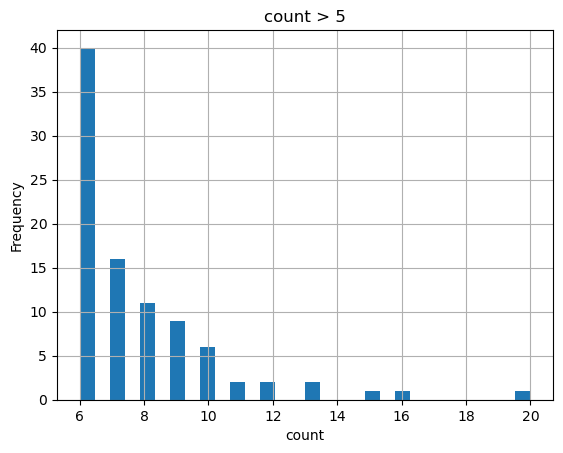

In [9]:
subset = edges[edges['count'] > 5]
subset['count'].hist(bins=30)
plt.xlabel('count')
plt.ylabel('Frequency')
plt.title('count > 5')
plt.show()

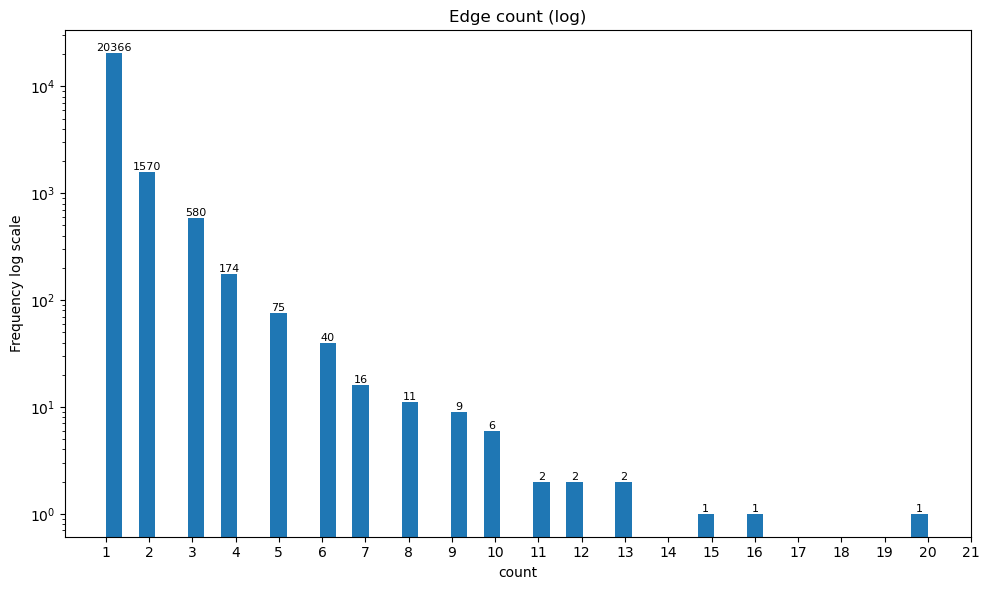

In [10]:
counts, bins = np.histogram(edges['count'], bins=50)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
plt.figure(figsize=(10, 6))
plt.bar(bin_centers, counts, width=(bins[1] - bins[0]))
plt.yscale('log')
plt.xlabel('count')
plt.ylabel('Frequency log scale')
plt.title('Edge count (log)')
for x, y in zip(bin_centers, counts):
    if y > 0:
        plt.text(x, y, str(y), ha='center', va='bottom', fontsize=8)
plt.xticks(np.arange(1, 22, 1))
plt.tight_layout()
plt.show()

In [11]:
import oat_python as oat

In [12]:
def createsubgraph(edges, n):
    edges_single = edges[edges['count'] >= n]
    concepts_used = set(edges_single['concept_source']) | set(edges_single['concept_target'])
    concepts_sub = concepts[concepts['concept'].isin(concepts_used)]

    G_sub = nx.Graph()

    G_sub.add_nodes_from([
        (c, {'norm_year': ny, 'count': ic}) 
        for c, ny, ic in zip(concepts_sub['concept'], concepts_sub['norm_year'], concepts_sub['count'])
    ])

    G_sub.add_edges_from([
        (u, v, {'norm_year': ny, 'count': ic}) 
        for u, v, ny, ic in zip(edges_single['concept_source'], edges_single['concept_target'],
                                edges_single['norm_year'], edges_single['count'])
    ])
    return G_sub

G_sub1 = createsubgraph(edges,1)
G_sub2 = createsubgraph(edges,2)
G_sub3 = createsubgraph(edges,3)
G_sub4 = createsubgraph(edges,4)

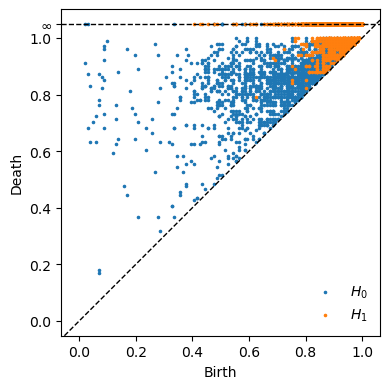

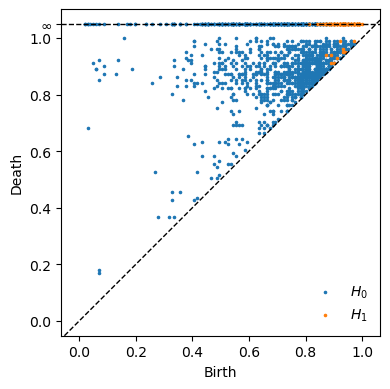

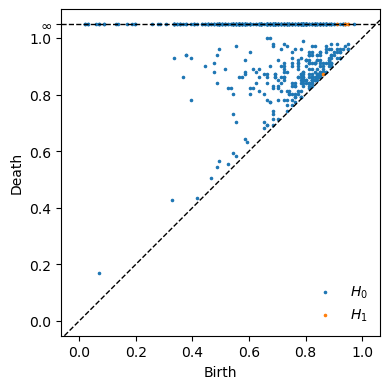

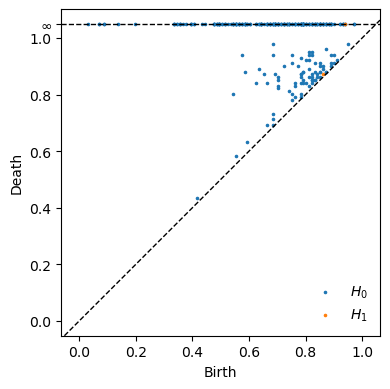

In [16]:
def gethomology(G_sub):
    node_list = list(G_sub.nodes) 
    node_index = {i: node_list[i] for i in range(len(node_list))}   
    reverse_index = {v: k for k, v in node_index.items()}           

    adj = nx.adjacency_matrix(G_sub, nodelist=node_list, weight='norm_year')
    adj.setdiag([G_sub.nodes[n]['norm_year'] for n in node_list])
    adj = adj.sorted_indices()

    factored = oat.rust.FactoredBoundaryMatrixVr(adj, 1)
    homology = factored.homology(
        return_cycle_representatives=True,
        return_bounding_chains=True
    )

    return homology, node_index 

def draw_persistent_diag(G_sub):
    homology,node = gethomology(G_sub)
    # initialize the plot
    fig, ax = plt.subplots()
    fig.set_figheight(4)
    fig.set_figwidth(4)
    infty = 1.05
    ax.set_xlabel('Birth')
    ax.set_ylabel('Death')
    ax.axis('equal')

    # lines
    ax.axhline(infty, ls='--', c='k', lw=1)
    ax.axline([0, 0], [1, 1], ls='--', c='k', lw=1)

    # loop, plot homology
    for dim in homology['dimension'].unique():
        dim_bc = homology[homology['dimension'] == dim]
        ax.scatter(dim_bc['birth'], dim_bc['death'].replace(np.inf, infty), s=2.5, label=f'$H_{dim}$')

    # final formatting
    ticks = ax.get_yticklabels()[1:-1]
    ticks.append(Text(0, infty, r'$\infty$'))  # add infty label
    ax.set_yticks(np.hstack((ax.get_yticks()[1:-1], infty)))
    ax.set_yticklabels(ticks)
    ax.legend(frameon=False)
    fig.tight_layout()

draw_persistent_diag(G_sub1)
draw_persistent_diag(G_sub2)
draw_persistent_diag(G_sub3)
draw_persistent_diag(G_sub4)

In [18]:
import ast
import re

In [21]:
df_homology1 = gethomology(G_sub1)
df_homology2 = gethomology(G_sub2)
df_homology3 = gethomology(G_sub3)
df_homology4 = gethomology(G_sub4)

def picklargestcycle(df_homology, node_index, max_filtration_val=1.05):
    df_H1 = df_homology[df_homology['dimension'] == 1].copy()
    df_H1['death_mod'] = df_H1['death'].replace(np.inf, max_filtration_val)
    df_H1['persistence'] = df_H1['death_mod'] - df_H1['birth']

    df_H1_sorted = df_H1.sort_values(by=['persistence', 'birth'], ascending=[False, True])
    target_bar = df_H1_sorted.iloc[0]
    print(f"Selected bar: birth={target_bar['birth']}, death={target_bar['death']}, persistence={target_bar['persistence']}")

    pattern_all = r"\[([0-9,\s]+)\]"
    matches = re.findall(pattern_all, str(target_bar['cycle representative']))

    edge_list = []
    for m in matches:
        local_nodes = list(map(int, m.strip().split(',')))
        real_nodes = [node_index[i] for i in local_nodes]  # 恢复原始 concept ID
        if len(real_nodes) == 2:
            edge_list.append(tuple(real_nodes))
        elif len(real_nodes) > 2:
            edge_list.extend([(real_nodes[i], real_nodes[(i+1)%len(real_nodes)]) for i in range(len(real_nodes))])

    node_set = set([n for edge in edge_list for n in edge])
    print("Nodes involved in generator:", node_set)
    print("Edges:", edge_list)

    return node_set, edge_list

Selected bar: birth=0.40594059405940597, death=inf, persistence=0.6440594059405941
Nodes involved in generator: {'oceanic water', 'british columbia', 'surface water temperature', 'deep water', 'english channel'}
Edges: [('british columbia', 'surface water temperature'), ('british columbia', 'oceanic water'), ('deep water', 'surface water temperature'), ('english channel', 'oceanic water'), ('deep water', 'english channel')]


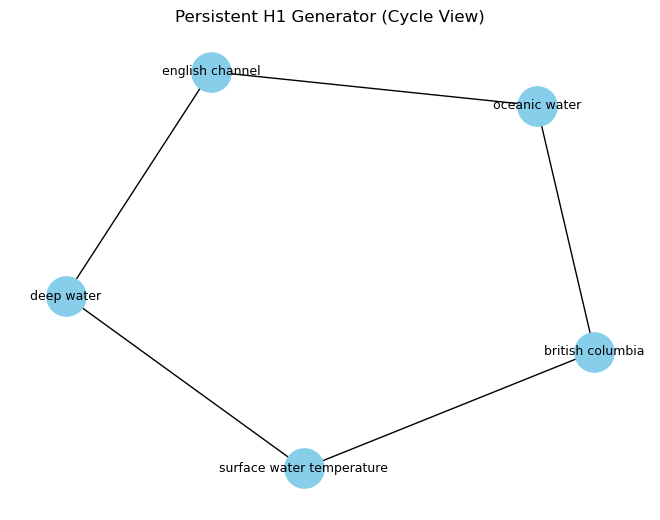

Selected bar: birth=0.8118811881188119, death=inf, persistence=0.2381188118811881
Nodes involved in generator: {'gene duplication event', 'gene duplication', 'neural crest', 'origin of vertebrate', 'early vertebrate evolution'}
Edges: [('gene duplication', 'origin of vertebrate'), ('early vertebrate evolution', 'neural crest'), ('early vertebrate evolution', 'gene duplication event'), ('gene duplication', 'gene duplication event'), ('neural crest', 'origin of vertebrate')]


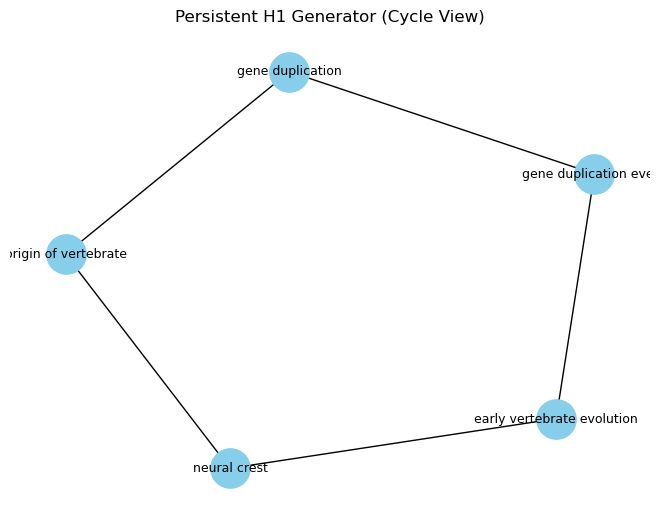

Selected bar: birth=0.9108910891089109, death=inf, persistence=0.13910891089108912
Nodes involved in generator: {'affective state', 'cognitive bias test', 'emotional state', 'cognitive bias'}
Edges: [('cognitive bias test', 'emotional state'), ('affective state', 'cognitive bias'), ('affective state', 'cognitive bias test'), ('cognitive bias', 'emotional state')]


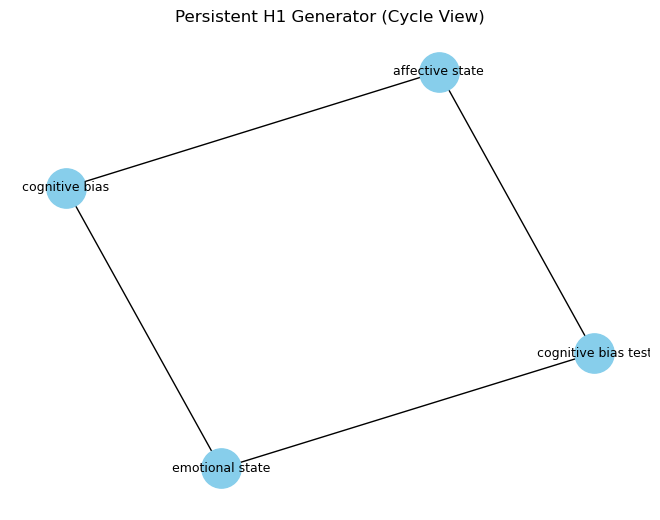

Selected bar: birth=0.9405940594059405, death=inf, persistence=0.1094059405940595
Nodes involved in generator: {'bt crop', 'evolution of resistance', 'bt maize', 'bacterium bacillus thuringiensis', 'field evolve resistance'}
Edges: [('bt maize', 'field evolve resistance'), ('bacterium bacillus thuringiensis', 'bt maize'), ('bt crop', 'field evolve resistance'), ('bacterium bacillus thuringiensis', 'evolution of resistance'), ('bt crop', 'evolution of resistance')]


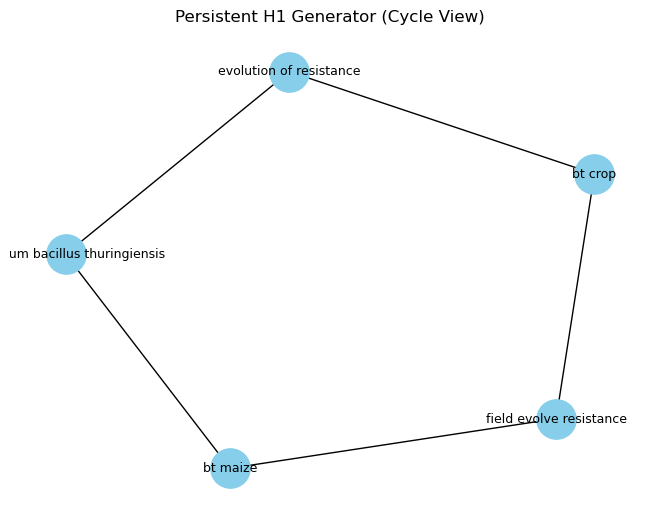

In [22]:
def drawlargecycle(df_homology, node_index, G_sub, max_filtration_val=1.05, show_labels=True):
    node_set, edge_list = picklargestcycle(df_homology, node_index, max_filtration_val)
    H = nx.Graph()
    H.add_nodes_from(node_set)
    H.add_edges_from(edge_list)
    pos = nx.spring_layout(H, seed=42)

    if show_labels:
        labels = {
            n: G_sub.nodes[n]['label'] if 'label' in G_sub.nodes[n] else str(n)
            for n in H.nodes
        }
    else:
        labels = None
    nx.draw(H, pos, with_labels=show_labels, labels=labels,
            node_color='skyblue', node_size=800, font_size=9)
    
    plt.title("Persistent H1 Generator (Cycle View)")
    plt.axis('off')
    plt.show()

df_homology1, node_index1 = gethomology(G_sub1)
df_homology2, node_index2 = gethomology(G_sub2)
df_homology3, node_index3 = gethomology(G_sub3)
df_homology4, node_index4 = gethomology(G_sub4)
drawlargecycle(df_homology1, node_index1, G_sub1)
drawlargecycle(df_homology2, node_index2, G_sub2)
drawlargecycle(df_homology3, node_index3, G_sub3)
drawlargecycle(df_homology4, node_index4, G_sub4)